In [1]:
import os
from google import genai
import ArxivQuery as aq
import Embed as eb

In [2]:
api_key = os.getenv("api_key")

def find_similar_papers(keyword, api_key, paper_n = 10):
    client = genai.Client(api_key = api_key)
    q = aq.ArxivQuery(keyword, paper_n)

    emb = eb.Embed(client)
    keywords = emb.extract_keywords(q.df)

    linked_papers = emb.link_papers(q.df, keywords)
    G = emb.build_graph_from_links(linked_papers)
    emb.display_graph_with_weights(G)

    return G

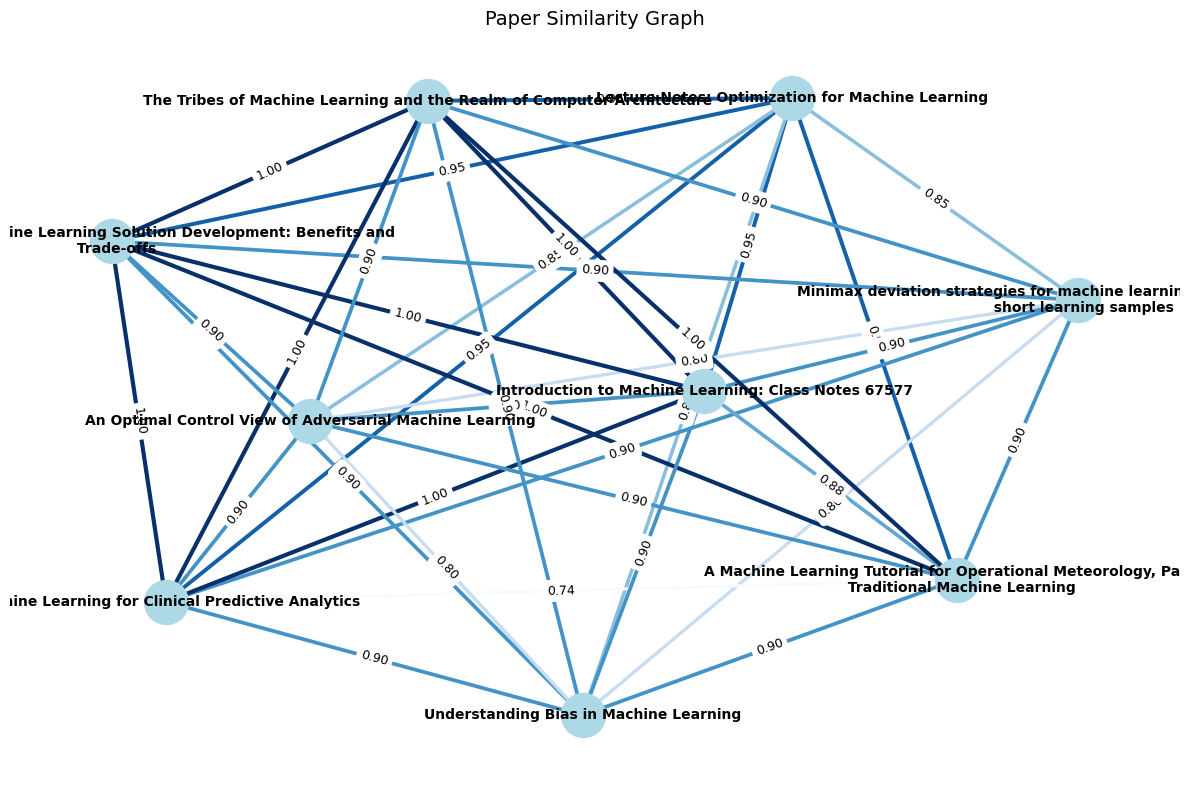

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}

In [ ]:
ML = find_similar_papers("machine learning", api_key, paper_n = 10)